In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import json

from preprocesslib import preprocessEach, makeY, makeYValue

In [2]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

In [3]:
def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [4]:
xValuesAll = np.concatenate((xValues, xOverlaps), axis=0)

In [5]:
xGrowthsAll = bootstrap(xValuesAll, xGrowths)

In [6]:
#make y values
yGrowths = makeYValue('growth', len(xGrowthsAll))
yValues = makeYValue('value', len(xValuesAll))

In [7]:
x = np.concatenate((xGrowthsAll, xValuesAll), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [8]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [9]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [10]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [11]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [12]:
x_train.shape #2570 data samples, 1248 days, 6 features

(2804, 1248, 6)

## Baseline model

In [16]:
model = Sequential()
model.add(LSTM(32, input_shape=(1248,6), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_value.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4992      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [18]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [19]:
#cross validation
x_split, y_split = splitDataCrossVal(x_train,y_train)
print(len(x_split))
accuracy_cross_val = []
for i in range(len(x_split)):
  x_train_cv, x_val, y_train_cv, y_val = splitData(x_split[i], y_split[i])
  x_train_cv = np.nan_to_num(x_train_cv, nan=0)
  x_val = np.nan_to_num(x_val, nan=0)

  history=model.fit(x_train_cv, y_train_cv, epochs=2000, batch_size=128, validation_data=(x_val, y_val), callbacks=[es, mc])
  model=load_model('best_model_value.h5')
  loss, accuracy = model.evaluate(x_val, y_val)
  accuracy_cross_val.append(accuracy)
  with open(f'history_value{i}.json', 'w') as f:
      json.dump(history.history, f)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

3
Epoch 1/2000
6/6 [==============================] - 6s 632ms/step - loss: 0.6921 - acc: 0.5261 - val_loss: 0.6861 - val_acc: 0.5508
Epoch 2/2000
6/6 [==============================] - 3s 578ms/step - loss: 0.6857 - acc: 0.5448 - val_loss: 0.6842 - val_acc: 0.5615
Epoch 3/2000
6/6 [==============================] - 3s 573ms/step - loss: 0.6885 - acc: 0.5248 - val_loss: 0.6824 - val_acc: 0.5882
Epoch 4/2000
6/6 [==============================] - 3s 532ms/step - loss: 0.6838 - acc: 0.5582 - val_loss: 0.6812 - val_acc: 0.5829
Epoch 5/2000
6/6 [==============================] - 3s 550ms/step - loss: 0.6734 - acc: 0.5837 - val_loss: 0.6798 - val_acc: 0.5722
Epoch 6/2000
6/6 [==============================] - 3s 595ms/step - loss: 0.6725 - acc: 0.5756 - val_loss: 0.6781 - val_acc: 0.5615
Epoch 7/2000
6/6 [==============================] - 3s 558ms/step - loss: 0.6718 - acc: 0.5797 - val_loss: 0.6770 - val_acc: 0.5775
Epoch 8/2000
6/6 [==============================] - 4s 623ms/step - loss: 

In [16]:
import json

history_dict = history.history
with open('history_value.json', 'w') as f:
    json.dump(history_dict, f)

In [17]:
# with open('history.json', 'r') as f:
#     loaded_history_dict = json.load(f)

In [50]:
count_0 = np.sum((y_test == [0]).all(axis=1))
count_1 = np.sum((y_test == [1]).all(axis=1))

print(f"[0]의 개수: {count_0}")
print(f"[1]의 개수: {count_1}")

[0]의 개수: 359
[1]의 개수: 343


In [19]:
best_model=load_model('best_model4.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
y_pred_prob = best_model.predict(x_test)

21/21 [==============================] - 1s 34ms/step


In [45]:
y_pred_prob

array([[0.87678057, 0.55694455],
       [0.7030248 , 0.6949826 ],
       [0.7373    , 0.6836126 ],
       ...,
       [0.7559437 , 0.67086065],
       [0.7318029 , 0.68486565],
       [0.73047936, 0.6860477 ]], dtype=float32)

In [44]:
y_pred_prob

array([[0.87678057, 0.55694455],
       [0.7030248 , 0.6949826 ],
       [0.7373    , 0.6836126 ],
       ...,
       [0.7559437 , 0.67086065],
       [0.7318029 , 0.68486565],
       [0.73047936, 0.6860477 ]], dtype=float32)

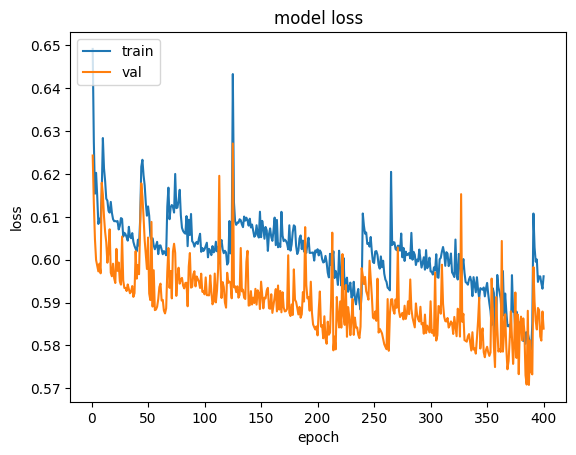

In [39]:
epochs = range(1, 401)
plt.plot(epochs, history.history['loss'][:400])
plt.plot(epochs, history.history['val_loss'][:400])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

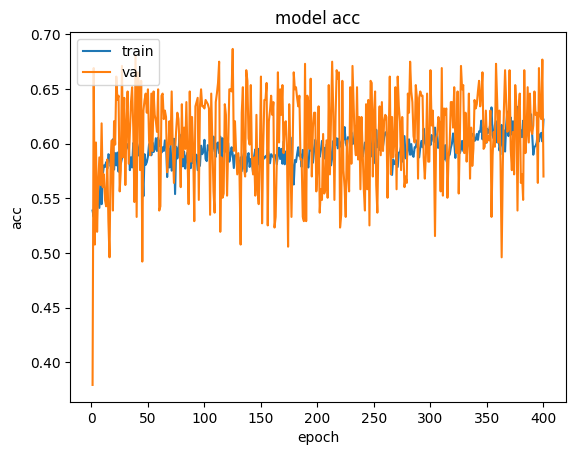

In [28]:
epochs = range(1, 401)
plt.plot(epochs, history.history['acc'][:400])
plt.plot(epochs, history.history['val_acc'][:400])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
with open('history0.json', 'r') as f:
    history_dict0 = json.load(f)
with open('history1.json', 'r') as f:
    history_dict1 = json.load(f)
with open('history2.json', 'r') as f:
    history_dict2 = json.load(f)

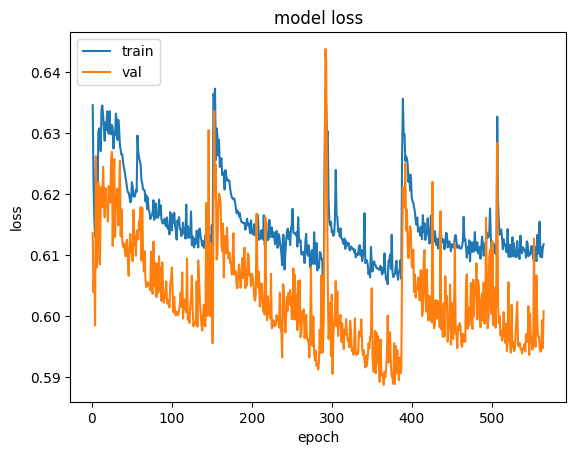

In [32]:
epochs0 = range(1, len(history_dict0['acc']) + 1)
plt.plot(epochs0, history_dict0['loss'])
plt.plot(epochs0, history_dict0['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

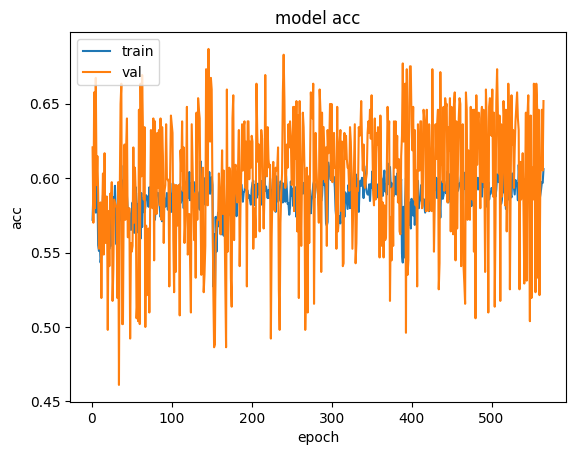

In [37]:
epochs0 = range(1, len(history_dict0['acc']) + 1)
plt.plot(epochs0, history_dict0['acc'])
plt.plot(epochs0, history_dict0['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()